<a href="https://colab.research.google.com/github/ApoorvaNagarajan/Image-Filter-Kernels/blob/master/assignment10/assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import all the required python libraries

from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.utils import np_utils
import cv2
from keras.applications import VGG16
import scipy
from keras.preprocessing.image import load_img
from keras.preprocessing import image
import keras
from keras.applications.vgg16 import preprocess_input

Using TensorFlow backend.


In [2]:
!wget https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg

--2019-07-11 15:25:18--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.245.83, 141.101.114.84, 190.93.247.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.245.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58670 (57K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’

16_scale_tony_stark 100%[===================>]  57.29K  --.-KB/s    in 0.01s   

2019-07-11 15:25:18 (4.73 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg’ saved [58670/58670]



In [3]:
# Build the VGG16 network with ImageNet weights
model = VGG16(weights='imagenet', include_top=True)

# load the image from file and resize it to 224x224
img = load_img('16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg', target_size=(224, 224))

W0711 15:25:19.767882 140559318468480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0711 15:25:19.813434 140559318468480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0711 15:25:19.820986 140559318468480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0711 15:25:19.858647 140559318468480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 6s 0us/step


W0711 15:25:26.527695 140559318468480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0711 15:25:26.528912 140559318468480 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



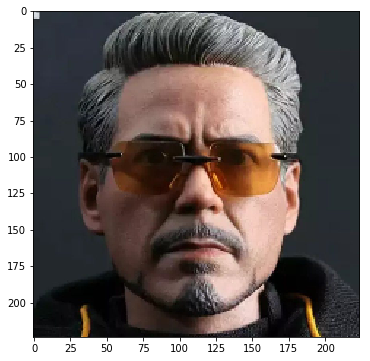

In [4]:
plt.rcParams['figure.figsize'] = (18, 6)
f, ax = plt.subplots(1, 1)
ax.imshow(img)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
# grad cam function to visualize layers of a model

def gradCam(pred, in_img, model, layer, numCh):
  class_idx = np.argmax(pred)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(numCh):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (224,224))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  img1 = np.uint8(image.img_to_array(in_img))
  superimposed_img = cv2.addWeighted(img1, 0.6, heatmap, 0.4, 0)
  return(img1,superimposed_img)

In [0]:
# Apply the same pre processing as VGG network

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# predict the class of the pre processed image
features = model.predict(x)

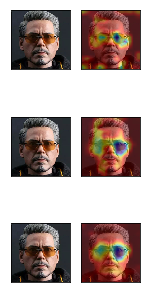

In [33]:
in_img1, sup_img1 = gradCam(features,img,model,"block5_conv1",512)
in_img2, sup_img2 = gradCam(features,img,model,"block5_conv2",512)
in_img3, sup_img3 = gradCam(features,img,model,"block5_conv3",512)


fig = plt.figure()

fig.add_subplot(3, 2, 1, xticks=[], yticks=[])
plt.imshow(in_img1)

fig.add_subplot(3, 2, 2, xticks=[], yticks=[])
plt.imshow(sup_img1)


fig.add_subplot(3, 2, 3, xticks=[], yticks=[])
plt.imshow(in_img2)

fig.add_subplot(3, 2, 4, xticks=[], yticks=[])
plt.imshow(sup_img2)

fig.add_subplot(3, 2, 5, xticks=[], yticks=[])
plt.imshow(in_img3)

fig.add_subplot(3, 2, 6, xticks=[], yticks=[])
plt.imshow(sup_img3)


plt.subplots_adjust(bottom=1.2, right=1.2, top=1.9, left=1.1)
plt.show()